In [1]:
# Character recognizer (Capitals) A to Z

In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [3]:
# data source : https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format?rvi=1
PATH = 'data/A_Z Handwritten Data.csv'
df = pd.read_csv(PATH).astype('float32')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 1.1 GB


In [5]:
alphabet_map = {i: chr(ord('A') + i) for i in range(26)}
alphabet_map

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
X, y = df.iloc[:,1:], df.iloc[:,0]
X = X.to_numpy().reshape(-1, 28, 28)
y = y.to_numpy()
X.shape

(372450, 28, 28)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(335205, 28, 28) (37245, 28, 28) (335205,) (37245,)


In [10]:
type(y_train)

numpy.ndarray

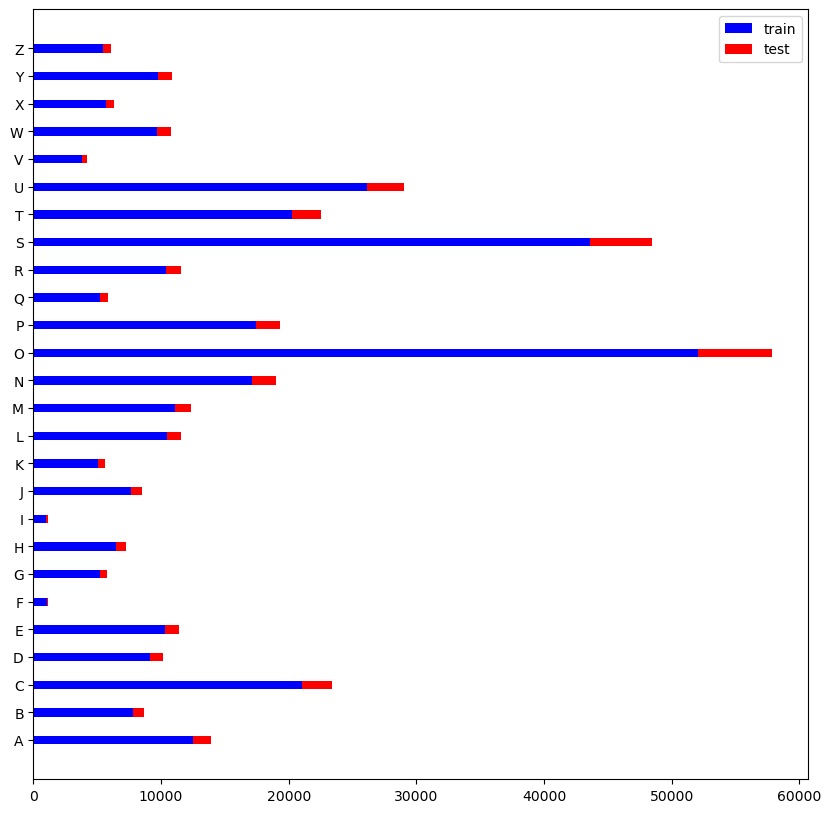

In [11]:
labels = list(alphabet_map.values())
np.count_nonzero(y_train == 9)
train_size, test_size = [], []
[(train_size.append((np.count_nonzero(y_train == i))), test_size.append((np.count_nonzero(y_test == i)))) for i in alphabet_map]

plt.figure(figsize=(10,10))
plt.barh(y=labels, width=train_size, color="blue", height=0.3)
plt.barh(y=labels, width=test_size, left=train_size, color="red", height=0.3)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
[(alphabet_map[i], np.count_nonzero(y_train == i), np.count_nonzero(y_test == i)) for i in alphabet_map]

[('A', 12482, 1387),
 ('B', 7801, 867),
 ('C', 21068, 2341),
 ('D', 9121, 1013),
 ('E', 10296, 1144),
 ('F', 1047, 116),
 ('G', 5186, 576),
 ('H', 6496, 722),
 ('I', 1008, 112),
 ('J', 7644, 849),
 ('K', 5043, 560),
 ('L', 10427, 1159),
 ('M', 11102, 1234),
 ('N', 17109, 1901),
 ('O', 52042, 5783),
 ('P', 17407, 1934),
 ('Q', 5231, 581),
 ('R', 10409, 1157),
 ('S', 43577, 4842),
 ('T', 20246, 2249),
 ('U', 26107, 2901),
 ('V', 3764, 418),
 ('W', 9706, 1078),
 ('X', 5645, 627),
 ('Y', 9773, 1086),
 ('Z', 5468, 608)]

3


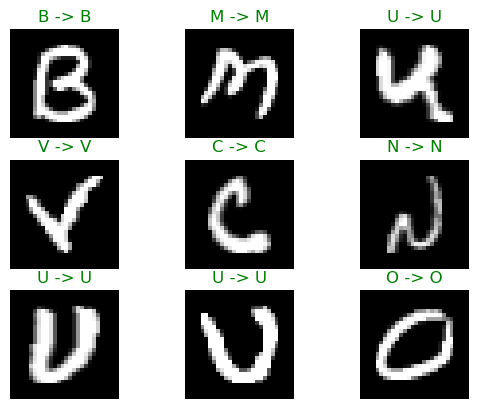

In [13]:
def show_img(X, y, pred):
    X = X.reshape(-1, 28, 28)
    y = y.reshape(-1, 1)
    pred = pred.reshape(-1, 1)
    rows = columns = math.ceil(X.shape[0]**0.5)
    print(rows)
    fig, axs = plt.subplots(rows, columns)
    for i in range(X.shape[0]):
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(X[i] , cmap='grey')
        plt.title(f'{alphabet_map[y[i].item()]} -> {alphabet_map[pred[i].item()]}', color=('red' if y[i].item()!=pred[i].item() else 'green'))
    plt.show()

sample_index = 200000
sample_size = 9
show_img(X_train[sample_index:sample_index+sample_size], y_train[sample_index:sample_index+sample_size], y_train[sample_index:sample_index+sample_size])

In [14]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 26)
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor, train=False):
        input = input.view(-1, 1, 28, 28)
        # size = X * 28*28 * 1
        
        output = self.relu(self.pool(self.conv1(input)))
        # size = X * 12*12 * 6
        output = self.relu(self.pool(self.conv2(output)))
        # size = X * 4*4 * 16
        
        output = output.view(-1, 16 * 4*4) # flattening
        # size = X * 256

        if train : output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)
        
        if train : output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)
        
        if train : output = self.dropout(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [15]:
class CharacterDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, device=None):
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.X = torch.Tensor(X).type(torch.float).to(device)
        self.y = torch.Tensor(y).type(torch.uint8).to(device)
        self.length = X.shape[0]
    def __getitem__(self, index):
        return self.X[index] ,self.y[index]
    def __len__(self):
        return self.length

In [72]:
epochs = 50
learning_rate = 0.0005
batch_size = 10000
model = Model(4*4*16, 120, 80).to(device)

train_dataset = CharacterDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size= 10000)

test_dataset = CharacterDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size= 10000)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
for i in range(epochs):
    print(f'epoch = {i}/{epochs}')
    for j, (X_batch, y_batch) in enumerate(train_loader):
        pred = model(X_batch, train=True)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        correct = 0 
        for j, (X_batch, y_batch) in enumerate(test_loader):
            pred_test = model(X_batch)
            pred_test = torch.argmax(pred_test, dim=1)
            correct += (pred_test==y_batch).sum().item()
        
        acc = 100 * (correct/len(test_dataset))
        print(f'loss = {loss.item():.3f}')
        print(f'accuracy = {acc:.3f}', end=2*'\n')
    
end_time = time.time()
print(f'total {end_time-start_time:.3f} seconds on {device}.')

epoch = 0/50
loss = 2.755
accuracy = 57.017

epoch = 1/50
loss = 2.571
accuracy = 77.221

epoch = 2/50
loss = 2.484
accuracy = 84.946

epoch = 3/50
loss = 2.442
accuracy = 89.515

epoch = 4/50
loss = 2.422
accuracy = 91.747

epoch = 5/50
loss = 2.406
accuracy = 92.906

epoch = 6/50
loss = 2.400
accuracy = 93.825

epoch = 7/50
loss = 2.391
accuracy = 94.525

epoch = 8/50
loss = 2.384
accuracy = 95.022

epoch = 9/50
loss = 2.382
accuracy = 95.237

epoch = 10/50
loss = 2.379
accuracy = 95.621

epoch = 11/50
loss = 2.374
accuracy = 95.795

epoch = 12/50
loss = 2.371
accuracy = 96.013

epoch = 13/50
loss = 2.369
accuracy = 96.193

epoch = 14/50
loss = 2.366
accuracy = 96.230

epoch = 15/50
loss = 2.365
accuracy = 96.367

epoch = 16/50
loss = 2.364
accuracy = 96.542

epoch = 17/50
loss = 2.368
accuracy = 96.657

epoch = 18/50
loss = 2.363
accuracy = 96.660

epoch = 19/50
loss = 2.362
accuracy = 96.732

epoch = 20/50
loss = 2.359
accuracy = 96.805

epoch = 21/50
loss = 2.357
accuracy = 96.829

In [73]:
pred_test = torch.Tensor().to(device)
for j, (X_batch, y_batch) in enumerate(test_loader):
    pred_batch = torch.argmax(model(X_batch), dim=1)
    pred_test = torch.cat((pred_test, pred_batch))
pred_test = pred_test.to('cpu')

conf_matrix = confusion_matrix(y_test, pred_test)
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i, acc in enumerate(accuracy_per_class):
    print(f'Accuracy "{alphabet_map[i]}": {acc*100:.2f}')

Accuracy "A": 99.50
Accuracy "B": 97.35
Accuracy "C": 98.38
Accuracy "D": 92.60
Accuracy "E": 98.51
Accuracy "F": 0.00
Accuracy "G": 95.14
Accuracy "H": 96.12
Accuracy "I": 0.00
Accuracy "J": 94.94
Accuracy "K": 95.00
Accuracy "L": 97.67
Accuracy "M": 97.89
Accuracy "N": 97.95
Accuracy "O": 99.46
Accuracy "P": 98.91
Accuracy "Q": 94.84
Accuracy "R": 96.54
Accuracy "S": 99.55
Accuracy "T": 99.11
Accuracy "U": 99.35
Accuracy "V": 98.33
Accuracy "W": 95.45
Accuracy "X": 97.61
Accuracy "Y": 97.24
Accuracy "Z": 98.19


In [74]:
# saving model
FILE = 'model.pth'
torch.save(model, FILE)